# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 100
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [ ]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return x/255


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

**Hint:**

Look into LabelBinarizer in the preprocessing module of sklearn.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    lb.fit(range(0,10))
    return lb.transform(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [2]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape = [None, *image_shape], name = 'x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape = [None, n_classes], name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name = 'keep_prob')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

** Hint: **

When unpacking values as an argument in Python, look into the [unpacking](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists) operator. 

In [3]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    weights = tf.Variable(tf.truncated_normal([*conv_ksize, x_tensor.get_shape().as_list()[3], conv_num_outputs], stddev = 0.05))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    conv = tf.nn.conv2d(x_tensor, weights, strides = [1, *conv_strides, 1], padding = 'SAME')
    conv =  tf.nn.bias_add(conv, bias)
    
    conv = tf.nn.max_pool(conv, ksize = [1, *pool_ksize, 1], strides = [1, *pool_strides, 1], padding = 'SAME')
    return conv 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [4]:
import numpy as np
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    return tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [5]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weights = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[1], num_outputs], stddev = 0.05))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    fc1 = tf.add(tf.matmul(x_tensor, weights), bias)
    
    return tf.nn.relu(fc1)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [6]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weights = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[1], num_outputs]))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    return tf.add(tf.matmul(x_tensor, weights), bias)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    #conv_layer = conv2d_maxpool(x, conv_num_outputs = 18, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize = (2,2), pool_strides = (2,2))
    #conv_layer = conv2d_maxpool(x, conv_num_outputs = 12, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize = (2,2), pool_strides = (2,2))
    #conv_layer = conv2d_maxpool(x, conv_num_outputs = 16, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize = (2,2), pool_strides = (2,2))
    conv_layer = conv2d_maxpool(x, conv_num_outputs = 18, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize = (3,3), pool_strides = (3,3))
    
    conv_layer = tf.nn.dropout(conv_layer, keep_prob)

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    flat_layer = flatten(conv_layer)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fully_connected_layer = fully_conn(flat_layer, 100)
    fully_connected_layer = tf.nn.dropout(fully_connected_layer, keep_prob)
    
    #conv_layer = fully_conn(conv_layer, 512)
    #conv_layer = tf.nn.dropout(conv_layer, keep_prob)
    
    #conv_layer = fully_conn(conv_layer, 256)
    #conv_layer = tf.nn.dropout(conv_layer, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    result = output(fully_connected_layer, 10)
    
    # TODO: return output
    return result


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict = {x : feature_batch, y : label_batch, keep_prob : keep_probability})
    pass


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [20]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    training_loss = session.run(cost, feed_dict = {x : feature_batch, y : label_batch, keep_prob : 1.0})
    training_accuracy = session.run(accuracy, feed_dict = {x : feature_batch, y : label_batch, keep_prob : 1.0})
    
    validation_loss = session.run(cost, feed_dict = {x : valid_features, y : valid_labels, keep_prob : 1.0})
    validation_accuracy = session.run(accuracy, feed_dict = {x : valid_features, y : valid_labels, keep_prob : 1.0})
    
    print('Training Loss : {}, Training Accuracy : {} '.format(training_loss, training_accuracy))
    print('Validation Loss : {}, Validation Accuracy : {} '.format(validation_loss, validation_accuracy))
    print('----------------------------------------------------------------------------------------')

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [15]:
# TODO: Tune Parameters
epochs = 100
batch_size = 256
keep_probability = 0.25

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  \n'.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  
Training Loss : 2.303384304046631, Training Accuracy : 0.07500000298023224 
Validation Loss : 2.3026838302612305, Validation Accuracy : 0.0997999981045723 
----------------------------------------------------------------------------------------
Epoch  2, CIFAR-10 Batch 1:  
Training Loss : 2.3031773567199707, Training Accuracy : 0.07500000298023224 
Validation Loss : 2.30265474319458, Validation Accuracy : 0.0997999981045723 
----------------------------------------------------------------------------------------
Epoch  3, CIFAR-10 Batch 1:  
Training Loss : 2.3030567169189453, Training Accuracy : 0.125 
Validation Loss : 2.302328586578369, Validation Accuracy : 0.10639999806880951 
----------------------------------------------------------------------------------------
Epoch  4, CIFAR-10 Batch 1:  
Training Loss : 2.3001160621643066, Training Accuracy : 0.125 
Validation Loss : 2.3003170490264893, Validation Accu

Epoch 31, CIFAR-10 Batch 1:  
Training Loss : 1.6221166849136353, Training Accuracy : 0.4749999940395355 
Validation Loss : 1.7514082193374634, Validation Accuracy : 0.40299999713897705 
----------------------------------------------------------------------------------------
Epoch 32, CIFAR-10 Batch 1:  
Training Loss : 1.3744453191757202, Training Accuracy : 0.574999988079071 
Validation Loss : 1.6098953485488892, Validation Accuracy : 0.45719999074935913 
----------------------------------------------------------------------------------------
Epoch 33, CIFAR-10 Batch 1:  
Training Loss : 1.4500573873519897, Training Accuracy : 0.6000000238418579 
Validation Loss : 1.6413054466247559, Validation Accuracy : 0.46320000290870667 
----------------------------------------------------------------------------------------
Epoch 34, CIFAR-10 Batch 1:  
Training Loss : 1.3857368230819702, Training Accuracy : 0.6000000238418579 
Validation Loss : 1.6031993627548218, Validation Accuracy : 0.47960

Epoch 62, CIFAR-10 Batch 1:  
Training Loss : 1.0623060464859009, Training Accuracy : 0.699999988079071 
Validation Loss : 1.44858980178833, Validation Accuracy : 0.5070000290870667 
----------------------------------------------------------------------------------------
Epoch 63, CIFAR-10 Batch 1:  
Training Loss : 1.0481733083724976, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.4519652128219604, Validation Accuracy : 0.524399995803833 
----------------------------------------------------------------------------------------
Epoch 64, CIFAR-10 Batch 1:  
Training Loss : 1.0530909299850464, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.4545655250549316, Validation Accuracy : 0.5117999911308289 
----------------------------------------------------------------------------------------
Epoch 65, CIFAR-10 Batch 1:  
Training Loss : 0.994071364402771, Training Accuracy : 0.800000011920929 
Validation Loss : 1.462565302848816, Validation Accuracy : 0.49700000882148

Training Loss : 0.8782058954238892, Training Accuracy : 0.824999988079071 
Validation Loss : 1.3848575353622437, Validation Accuracy : 0.5374000072479248 
----------------------------------------------------------------------------------------
Epoch 93, CIFAR-10 Batch 1:  
Training Loss : 0.850847601890564, Training Accuracy : 0.875 
Validation Loss : 1.3895946741104126, Validation Accuracy : 0.5375999808311462 
----------------------------------------------------------------------------------------
Epoch 94, CIFAR-10 Batch 1:  
Training Loss : 0.9420136213302612, Training Accuracy : 0.8500000238418579 
Validation Loss : 1.4208852052688599, Validation Accuracy : 0.522599995136261 
----------------------------------------------------------------------------------------
Epoch 95, CIFAR-10 Batch 1:  
Training Loss : 0.8313922882080078, Training Accuracy : 0.925000011920929 
Validation Loss : 1.3644347190856934, Validation Accuracy : 0.5374000072479248 
------------------------------------

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Training Loss : 2.301827907562256, Training Accuracy : 0.125 
Validation Loss : 2.3027689456939697, Validation Accuracy : 0.10180000215768814 
----------------------------------------------------------------------------------------
Epoch  1, CIFAR-10 Batch 2:  Training Loss : 2.3018441200256348, Training Accuracy : 0.125 
Validation Loss : 2.3026814460754395, Validation Accuracy : 0.10199999809265137 
----------------------------------------------------------------------------------------
Epoch  1, CIFAR-10 Batch 3:  Training Loss : 2.2958996295928955, Training Accuracy : 0.125 
Validation Loss : 2.294618844985962, Validation Accuracy : 0.10719999670982361 
----------------------------------------------------------------------------------------
Epoch  1, CIFAR-10 Batch 4:  Training Loss : 2.2896475791931152, Training Accuracy : 0.125 
Validation Loss : 2.286214828491211, Validation Accuracy : 0.11060000211000443 
--------------------------------

Epoch  7, CIFAR-10 Batch 2:  Training Loss : 1.6156456470489502, Training Accuracy : 0.42500001192092896 
Validation Loss : 1.6626183986663818, Validation Accuracy : 0.4562000036239624 
----------------------------------------------------------------------------------------
Epoch  7, CIFAR-10 Batch 3:  Training Loss : 1.4622567892074585, Training Accuracy : 0.6499999761581421 
Validation Loss : 1.5903809070587158, Validation Accuracy : 0.46860000491142273 
----------------------------------------------------------------------------------------
Epoch  7, CIFAR-10 Batch 4:  Training Loss : 1.452393889427185, Training Accuracy : 0.5249999761581421 
Validation Loss : 1.579304814338684, Validation Accuracy : 0.4749999940395355 
----------------------------------------------------------------------------------------
Epoch  7, CIFAR-10 Batch 5:  Training Loss : 1.617902398109436, Training Accuracy : 0.5 
Validation Loss : 1.5913941860198975, Validation Accuracy : 0.48539999127388 
-----------

Epoch 13, CIFAR-10 Batch 3:  Training Loss : 1.295581340789795, Training Accuracy : 0.675000011920929 
Validation Loss : 1.4458688497543335, Validation Accuracy : 0.527400016784668 
----------------------------------------------------------------------------------------
Epoch 13, CIFAR-10 Batch 4:  Training Loss : 1.276012659072876, Training Accuracy : 0.5249999761581421 
Validation Loss : 1.4351818561553955, Validation Accuracy : 0.5239999890327454 
----------------------------------------------------------------------------------------
Epoch 13, CIFAR-10 Batch 5:  Training Loss : 1.4612191915512085, Training Accuracy : 0.625 
Validation Loss : 1.4689621925354004, Validation Accuracy : 0.5126000046730042 
----------------------------------------------------------------------------------------
Epoch 14, CIFAR-10 Batch 1:  Training Loss : 1.4450629949569702, Training Accuracy : 0.6000000238418579 
Validation Loss : 1.458663821220398, Validation Accuracy : 0.5148000121116638 
-----------

Epoch 19, CIFAR-10 Batch 4:  Training Loss : 1.1222087144851685, Training Accuracy : 0.6499999761581421 
Validation Loss : 1.3451887369155884, Validation Accuracy : 0.5446000099182129 
----------------------------------------------------------------------------------------
Epoch 19, CIFAR-10 Batch 5:  Training Loss : 1.3618090152740479, Training Accuracy : 0.6499999761581421 
Validation Loss : 1.3998615741729736, Validation Accuracy : 0.534600019454956 
----------------------------------------------------------------------------------------
Epoch 20, CIFAR-10 Batch 1:  Training Loss : 1.3018206357955933, Training Accuracy : 0.675000011920929 
Validation Loss : 1.4228572845458984, Validation Accuracy : 0.5252000093460083 
----------------------------------------------------------------------------------------
Epoch 20, CIFAR-10 Batch 2:  Training Loss : 1.1804485321044922, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.438222050666809, Validation Accuracy : 0.53039997816085

Epoch 25, CIFAR-10 Batch 5:  Training Loss : 1.2986899614334106, Training Accuracy : 0.625 
Validation Loss : 1.3291776180267334, Validation Accuracy : 0.5587999820709229 
----------------------------------------------------------------------------------------
Epoch 26, CIFAR-10 Batch 1:  Training Loss : 1.2219805717468262, Training Accuracy : 0.675000011920929 
Validation Loss : 1.3596251010894775, Validation Accuracy : 0.5464000105857849 
----------------------------------------------------------------------------------------
Epoch 26, CIFAR-10 Batch 2:  Training Loss : 1.0859031677246094, Training Accuracy : 0.75 
Validation Loss : 1.371241569519043, Validation Accuracy : 0.5370000004768372 
----------------------------------------------------------------------------------------
Epoch 26, CIFAR-10 Batch 3:  Training Loss : 1.0770004987716675, Training Accuracy : 0.625 
Validation Loss : 1.3176202774047852, Validation Accuracy : 0.5472000241279602 
-----------------------------------

Epoch 32, CIFAR-10 Batch 1:  Training Loss : 1.141300916671753, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.3124544620513916, Validation Accuracy : 0.5684000253677368 
----------------------------------------------------------------------------------------
Epoch 32, CIFAR-10 Batch 2:  Training Loss : 1.0345076322555542, Training Accuracy : 0.699999988079071 
Validation Loss : 1.3456472158432007, Validation Accuracy : 0.5508000254631042 
----------------------------------------------------------------------------------------
Epoch 32, CIFAR-10 Batch 3:  Training Loss : 1.0101420879364014, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.2720825672149658, Validation Accuracy : 0.5658000111579895 
----------------------------------------------------------------------------------------
Epoch 32, CIFAR-10 Batch 4:  Training Loss : 0.9935022592544556, Training Accuracy : 0.699999988079071 
Validation Loss : 1.2790061235427856, Validation Accuracy : 0.57059997320175

Epoch 38, CIFAR-10 Batch 2:  Training Loss : 1.030064344406128, Training Accuracy : 0.800000011920929 
Validation Loss : 1.3458285331726074, Validation Accuracy : 0.5633999705314636 
----------------------------------------------------------------------------------------
Epoch 38, CIFAR-10 Batch 3:  Training Loss : 1.0512416362762451, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.2868587970733643, Validation Accuracy : 0.5734000205993652 
----------------------------------------------------------------------------------------
Epoch 38, CIFAR-10 Batch 4:  Training Loss : 1.0437644720077515, Training Accuracy : 0.675000011920929 
Validation Loss : 1.308869481086731, Validation Accuracy : 0.5662000179290771 
----------------------------------------------------------------------------------------
Epoch 38, CIFAR-10 Batch 5:  Training Loss : 1.248395323753357, Training Accuracy : 0.675000011920929 
Validation Loss : 1.341961145401001, Validation Accuracy : 0.5532000064849854 


Epoch 44, CIFAR-10 Batch 3:  Training Loss : 0.9725297689437866, Training Accuracy : 0.824999988079071 
Validation Loss : 1.2409898042678833, Validation Accuracy : 0.5834000110626221 
----------------------------------------------------------------------------------------
Epoch 44, CIFAR-10 Batch 4:  Training Loss : 0.9279346466064453, Training Accuracy : 0.699999988079071 
Validation Loss : 1.2516860961914062, Validation Accuracy : 0.5676000118255615 
----------------------------------------------------------------------------------------
Epoch 44, CIFAR-10 Batch 5:  Training Loss : 1.1012115478515625, Training Accuracy : 0.699999988079071 
Validation Loss : 1.2383410930633545, Validation Accuracy : 0.5781999826431274 
----------------------------------------------------------------------------------------
Epoch 45, CIFAR-10 Batch 1:  Training Loss : 1.0861703157424927, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.3018765449523926, Validation Accuracy : 0.56699997186660

Epoch 50, CIFAR-10 Batch 4:  Training Loss : 0.9289444088935852, Training Accuracy : 0.75 
Validation Loss : 1.2442688941955566, Validation Accuracy : 0.5827999711036682 
----------------------------------------------------------------------------------------
Epoch 50, CIFAR-10 Batch 5:  Training Loss : 1.13516366481781, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.2384724617004395, Validation Accuracy : 0.5825999975204468 
----------------------------------------------------------------------------------------
Epoch 51, CIFAR-10 Batch 1:  Training Loss : 1.0417524576187134, Training Accuracy : 0.699999988079071 
Validation Loss : 1.2573671340942383, Validation Accuracy : 0.5809999704360962 
----------------------------------------------------------------------------------------
Epoch 51, CIFAR-10 Batch 2:  Training Loss : 0.9767671823501587, Training Accuracy : 0.699999988079071 
Validation Loss : 1.2897697687149048, Validation Accuracy : 0.5598000288009644 
-----------

Epoch 56, CIFAR-10 Batch 5:  Training Loss : 1.1735031604766846, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.2729508876800537, Validation Accuracy : 0.5658000111579895 
----------------------------------------------------------------------------------------
Epoch 57, CIFAR-10 Batch 1:  Training Loss : 1.075387716293335, Training Accuracy : 0.75 
Validation Loss : 1.2921509742736816, Validation Accuracy : 0.5745999813079834 
----------------------------------------------------------------------------------------
Epoch 57, CIFAR-10 Batch 2:  Training Loss : 1.0225706100463867, Training Accuracy : 0.824999988079071 
Validation Loss : 1.3235417604446411, Validation Accuracy : 0.5680000185966492 
----------------------------------------------------------------------------------------
Epoch 57, CIFAR-10 Batch 3:  Training Loss : 0.9611080288887024, Training Accuracy : 0.875 
Validation Loss : 1.2219852209091187, Validation Accuracy : 0.592199981212616 
-----------------------

Epoch 63, CIFAR-10 Batch 1:  Training Loss : 1.0478734970092773, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.256544828414917, Validation Accuracy : 0.5853999853134155 
----------------------------------------------------------------------------------------
Epoch 63, CIFAR-10 Batch 2:  Training Loss : 0.9015083312988281, Training Accuracy : 0.824999988079071 
Validation Loss : 1.2714498043060303, Validation Accuracy : 0.5770000219345093 
----------------------------------------------------------------------------------------
Epoch 63, CIFAR-10 Batch 3:  Training Loss : 0.967432975769043, Training Accuracy : 0.824999988079071 
Validation Loss : 1.226253867149353, Validation Accuracy : 0.5849999785423279 
----------------------------------------------------------------------------------------
Epoch 63, CIFAR-10 Batch 4:  Training Loss : 0.9626482129096985, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.2320829629898071, Validation Accuracy : 0.5879999995231628

Epoch 69, CIFAR-10 Batch 2:  Training Loss : 0.9410790205001831, Training Accuracy : 0.824999988079071 
Validation Loss : 1.283371925354004, Validation Accuracy : 0.5763999819755554 
----------------------------------------------------------------------------------------
Epoch 69, CIFAR-10 Batch 3:  Training Loss : 0.9524730443954468, Training Accuracy : 0.8500000238418579 
Validation Loss : 1.2075532674789429, Validation Accuracy : 0.5878000259399414 
----------------------------------------------------------------------------------------
Epoch 69, CIFAR-10 Batch 4:  Training Loss : 0.909491240978241, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.213133692741394, Validation Accuracy : 0.5867999792098999 
----------------------------------------------------------------------------------------
Epoch 69, CIFAR-10 Batch 5:  Training Loss : 1.0991382598876953, Training Accuracy : 0.699999988079071 
Validation Loss : 1.2328089475631714, Validation Accuracy : 0.5871999859809875

Epoch 75, CIFAR-10 Batch 2:  Training Loss : 0.9686034321784973, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.265475869178772, Validation Accuracy : 0.5809999704360962 
----------------------------------------------------------------------------------------
Epoch 75, CIFAR-10 Batch 3:  Training Loss : 0.9102818369865417, Training Accuracy : 0.824999988079071 
Validation Loss : 1.1864819526672363, Validation Accuracy : 0.5978000164031982 
----------------------------------------------------------------------------------------
Epoch 75, CIFAR-10 Batch 4:  Training Loss : 0.8917055130004883, Training Accuracy : 0.800000011920929 
Validation Loss : 1.2016019821166992, Validation Accuracy : 0.5978000164031982 
----------------------------------------------------------------------------------------
Epoch 75, CIFAR-10 Batch 5:  Training Loss : 1.0561578273773193, Training Accuracy : 0.699999988079071 
Validation Loss : 1.2384295463562012, Validation Accuracy : 0.586600005626678

Epoch 81, CIFAR-10 Batch 3:  Training Loss : 0.9534837007522583, Training Accuracy : 0.8500000238418579 
Validation Loss : 1.2294505834579468, Validation Accuracy : 0.5835999846458435 
----------------------------------------------------------------------------------------
Epoch 81, CIFAR-10 Batch 4:  Training Loss : 0.9390830993652344, Training Accuracy : 0.75 
Validation Loss : 1.219018578529358, Validation Accuracy : 0.5992000102996826 
----------------------------------------------------------------------------------------
Epoch 81, CIFAR-10 Batch 5:  Training Loss : 1.0621178150177002, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.2237119674682617, Validation Accuracy : 0.5911999940872192 
----------------------------------------------------------------------------------------
Epoch 82, CIFAR-10 Batch 1:  Training Loss : 0.9674779772758484, Training Accuracy : 0.675000011920929 
Validation Loss : 1.2147213220596313, Validation Accuracy : 0.5982000231742859 
---------

Epoch 87, CIFAR-10 Batch 4:  Training Loss : 0.938895046710968, Training Accuracy : 0.824999988079071 
Validation Loss : 1.2170796394348145, Validation Accuracy : 0.592199981212616 
----------------------------------------------------------------------------------------
Epoch 87, CIFAR-10 Batch 5:  Training Loss : 1.0959603786468506, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.230294942855835, Validation Accuracy : 0.5842000246047974 
----------------------------------------------------------------------------------------
Epoch 88, CIFAR-10 Batch 1:  Training Loss : 0.9978374242782593, Training Accuracy : 0.7250000238418579 
Validation Loss : 1.2234381437301636, Validation Accuracy : 0.593999981880188 
----------------------------------------------------------------------------------------
Epoch 88, CIFAR-10 Batch 2:  Training Loss : 0.8902546167373657, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.200137972831726, Validation Accuracy : 0.5985999703407288 

Epoch 93, CIFAR-10 Batch 5:  Training Loss : 1.042716145515442, Training Accuracy : 0.75 
Validation Loss : 1.1894078254699707, Validation Accuracy : 0.5928000211715698 
----------------------------------------------------------------------------------------
Epoch 94, CIFAR-10 Batch 1:  Training Loss : 0.9630861282348633, Training Accuracy : 0.699999988079071 
Validation Loss : 1.1999763250350952, Validation Accuracy : 0.5996000170707703 
----------------------------------------------------------------------------------------
Epoch 94, CIFAR-10 Batch 2:  Training Loss : 0.9847257733345032, Training Accuracy : 0.800000011920929 
Validation Loss : 1.238430142402649, Validation Accuracy : 0.5924000144004822 
----------------------------------------------------------------------------------------
Epoch 94, CIFAR-10 Batch 3:  Training Loss : 0.9105526804924011, Training Accuracy : 0.8999999761581421 
Validation Loss : 1.1812033653259277, Validation Accuracy : 0.5971999764442444 
-----------

Epoch 100, CIFAR-10 Batch 1:  Training Loss : 0.9384816288948059, Training Accuracy : 0.7749999761581421 
Validation Loss : 1.2127281427383423, Validation Accuracy : 0.600600004196167 
----------------------------------------------------------------------------------------
Epoch 100, CIFAR-10 Batch 2:  Training Loss : 0.9150176048278809, Training Accuracy : 0.824999988079071 
Validation Loss : 1.2302956581115723, Validation Accuracy : 0.5953999757766724 
----------------------------------------------------------------------------------------
Epoch 100, CIFAR-10 Batch 3:  Training Loss : 0.9095573425292969, Training Accuracy : 0.875 
Validation Loss : 1.189431071281433, Validation Accuracy : 0.5996000170707703 
----------------------------------------------------------------------------------------
Epoch 100, CIFAR-10 Batch 4:  Training Loss : 0.926803469657898, Training Accuracy : 0.800000011920929 
Validation Loss : 1.2044620513916016, Validation Accuracy : 0.5964000225067139 
-------

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.59638671875



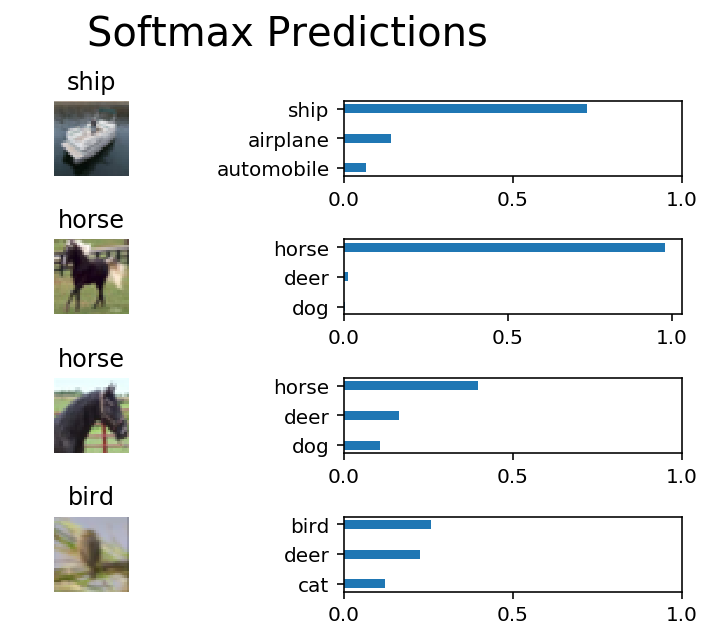

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. That's because there are many more techniques that can be applied to your model and we recemmond that once you are done with this project, you explore!

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.